# Import Required Libraries

In [ ]:
! pip install nltk

In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt 
from uszipcode import SearchEngine
from sklearn.cluster import KMeans
import nltk
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

c:\Users\adnan\anaconda3\envs\DNN\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
# Fixing csv file which stored with different enconding
pd.read_csv('FileName.csv', sep=';', encoding='ISO-8859-1')

In [2]:
movies_data = pd.read_csv('movies_modif.csv')
movies_data = movies_data.drop('Unnamed: 3', axis=1)
rating_data=pd.read_csv('ratings_modif.csv')
users_data = pd.read_csv('users modif (1).csv')
# ------------------------------------------------------------------------------
movies_data['genres'] = movies_data['genres'].str.replace("|", " ")
movies_data['genres'] = movies_data['genres'].str.replace("'", "")

movies_data

c:\Users\adnan\anaconda3\envs\DNN\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


,movieId,title,genres
0,1,Toy Story (1995),Animation Childrens Comedy
1,2,Jumanji (1995),Adventure Childrens Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# Content-based filtering approach

In [3]:
# Apply TF-IDF on movie genres
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the genres records
tfidf_matrix = vectorizer.fit_transform(movies_data['genres'])
# Vectorization Results of the 3 genres of the first movie (Animation, Childrens, Comedy)
print(tfidf_matrix[0])

  (0, 84)	0.3415905097237401
  (0, 79)	0.5961977985991829
  (0, 45)	0.726542571782386


In [4]:
# Function to extract release year from movie title using regix
def extract_release_year(title):
    pattern = r"\((\d{4})\)$"
    match = re.search(pattern, title)
    if match:
        # print(match.group(1))
        return int(match.group(1))
    else:
        return None

In [5]:
# Calculate cosine similarity matrix
cosine_similarities = cosine_similarity(tfidf_matrix)

# Extract movie release year from title to be used in sorting
movies_data['release_year']= [extract_release_year(movie) for movie in movies_data['title']]

# Get the first N movies in the dataset
movies_subset = movies_data.head(2)

# Loop through each movie in the subset
similar_movies = {}
release_year_diff=[]
for idx, movie in enumerate(movies_subset['title']):
    # Get cosine similarity scores for the current movie
    similarity_scores = list(enumerate(cosine_similarities[idx]))

    # Sort by 'similarity' in descending order as primary condition,
    # and by absolute difference between 'release_year' and 'target_year' as secondary condition
    target_year = movies_subset['release_year'][idx] # target year for release date comparison
    movies_data['release_year_diff'] = abs(movies_data['release_year'] - target_year)

    # Sort similarity scores in descending order
    similarity_scores = sorted(similarity_scores, key=lambda x: (x[1], -movies_data.iloc[x[0]]['release_year_diff']), reverse=True)

    # Get top 10 similar movies (excluding the current movie itself)
    top_10_similar_movies = [(movies_data.iloc[similarity_score[0]]['title'], similarity_score[1]) for similarity_score in similarity_scores if similarity_score[0] != idx][:20]
 
    # Add similar movies to the dictionary (with "Current movie Title as a Key")
    similar_movies[movie] = top_10_similar_movies

In [6]:
# Print similar movies for each movie
for movie, similar_movie_scores in similar_movies.items():
    print("Similar movies for '{}' are:".format(movie))
    for similar_movie in similar_movie_scores:
        Recomended_Movie_Title = similar_movie[0]
        Recomended_Movie_similarity_with_user_movie = round(similar_movie[1], 4)
        print("- '{}' with similarity score {}".format(Recomended_Movie_Title, Recomended_Movie_similarity_with_user_movie))
    print("------------------------")

Similar movies for 'Toy Story (1995)' are:
- 'Aladdin and the King of Thieves (1996)' with similarity score 1.0
- 'Rugrats Movie, The (1998)' with similarity score 1.0
- 'Bug's Life, A (1998)' with similarity score 1.0
- 'Toy Story 2 (1999)' with similarity score 1.0
- 'Chicken Run (2000)' with similarity score 1.0
- 'Adventures of Rocky and Bullwinkle, The (2000)' with similarity score 1.0
- 'American Tail, An (1986)' with similarity score 1.0
- 'Saludos Amigos (1943)' with similarity score 1.0
- 'Balto (1995)' with similarity score 0.9398
- 'Swan Princess, The (1994)' with similarity score 0.9398
- 'Thumbelina (1994)' with similarity score 0.9398
- 'We're Back! A Dinosaur's Story (1993)' with similarity score 0.9398
- 'Mulan (1998)' with similarity score 0.9398
- 'Antz (1998)' with similarity score 0.9398
- 'King and I, The (1999)' with similarity score 0.9398
- 'Doug's 1st Movie (1999)' with similarity score 0.9398
- 'Tarzan (1999)' with similarity score 0.9398
- 'Iron Giant, The (1

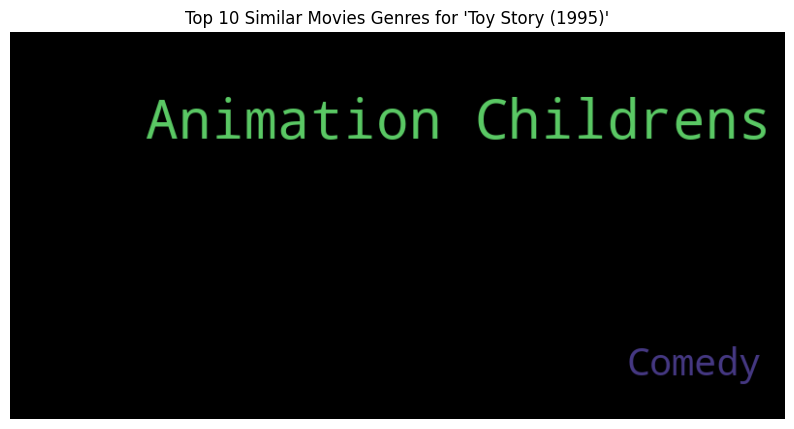

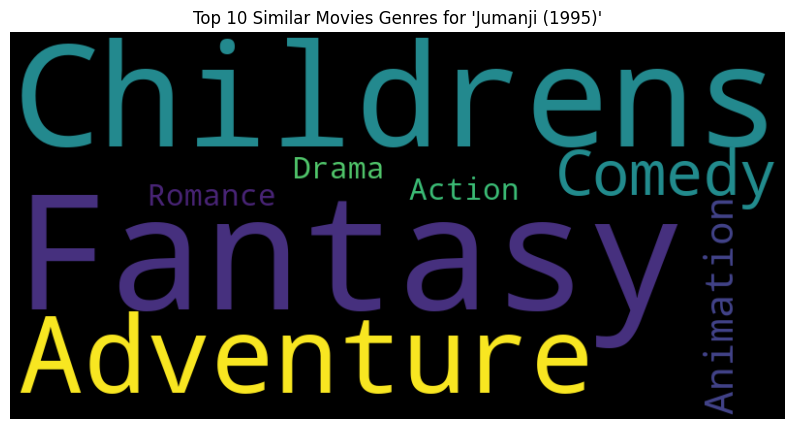

In [10]:
# Import WordCloud
from wordcloud import WordCloud

# Loop through each movie in the similar_movies dictionary
for movie, similar_movie_scores in similar_movies.items():
    # Get the genres of recommended movies
    recommended_genres = " ".join([movies_data[movies_data['title'] == similar_movie[0]]['genres'].values[0] for similar_movie in similar_movie_scores])

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=50).generate(recommended_genres)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top 10 Similar Movies Genres for '{}'".format(movie))
    plt.show()


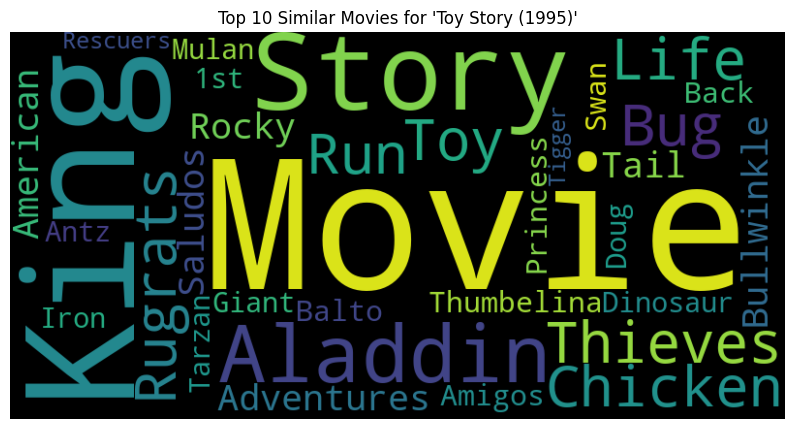

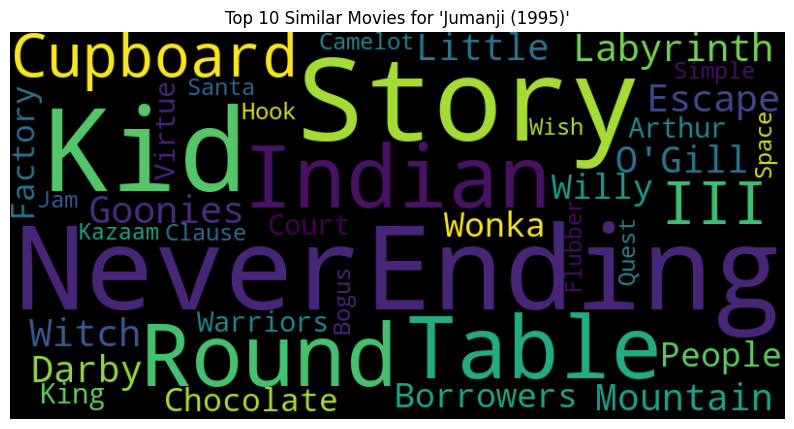

In [23]:
# Loop through each movie in the similar_movies dictionary
for movie, similar_movie_scores in similar_movies.items():
    # Get the titles of recommended movies
    recommended_movies = [similar_movie[0] for similar_movie in similar_movie_scores]

    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=50).generate(" ".join(recommended_movies))

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Top 10 Similar Movies for '{}'".format(movie))
    plt.show()


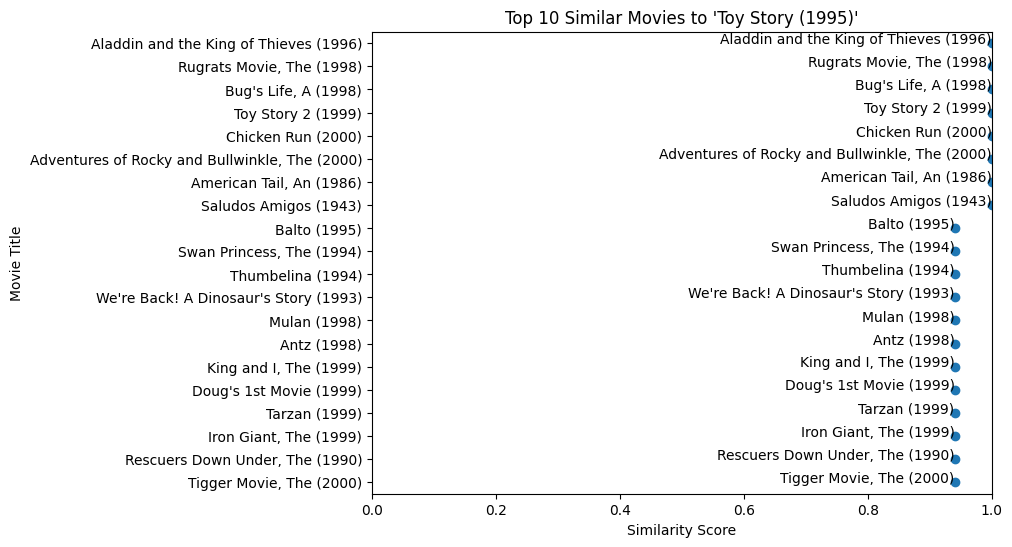

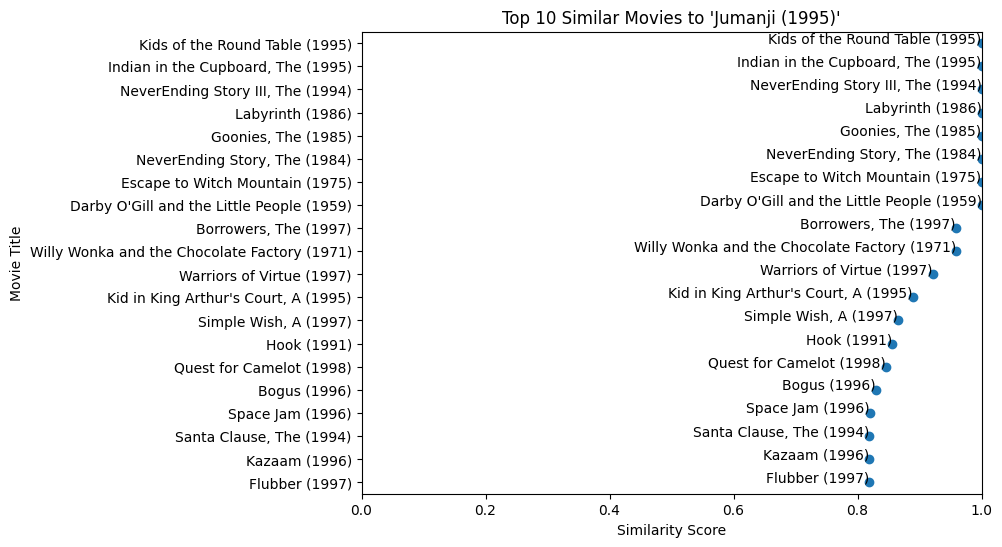

In [56]:
import matplotlib.pyplot as plt

for movie, similar_movie_scores in similar_movies.items():
    # Create a list of similar movie titles and similarity scores
    movie_titles = [m[0] for m in similar_movie_scores][::-1]
    similarity_scores = [m[1] for m in similar_movie_scores][::-1]

    # Create a scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(similarity_scores, movie_titles)
    # Set the x-axis label and limits
    plt.xlabel("Similarity Score")
    plt.xlim(0, 1)

    # Set the y-axis labels and limits
    plt.ylabel("Movie Title")
    plt.ylim(-0.5, len(movie_titles)-0.5)

    # Add a title to the plot
    plt.title(f"Top 10 Similar Movies to '{movie}'")

    # Add labels for each point in the scatter plot
    for i, title in enumerate(movie_titles):
        plt.annotate(title, (similarity_scores[i], i), ha="right")

    # Show the plot
    plt.show()


# Item-based collaborative filtering approach

In [ ]:
movies_data = pd.read_csv('movies_modif.csv')
movies_data = movies_data.drop('Unnamed: 3', axis=1)
rating_data=pd.read_csv('ratings_modif.csv')
users_data = pd.read_csv('users modif (1).csv')
# ------------------------------------------------------------------------------
movies_data['genres'] = movies_data['genres'].str.replace("|", " ")
movies_data['genres'] = movies_data['genres'].str.replace("'", "")

# Initialize search engine
search = SearchEngine()

# Function to get state from zip code
def get_state_from_zip(zip_code):
    result = search.by_zipcode(zip_code)
    if result:
        state = result.state
        return state
    else:
        return None

In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Encode 'gender' column
users_data['gender_encoded'] = label_encoder.fit_transform(users_data['gender'])

# Normalize 'age' column
users_data['age_normalized'] = scaler.fit_transform(users_data[['age']])

# Normalize 'age' column
users_data['occupation_normalized'] = scaler.fit_transform(users_data[['occupation']])

# Apply the get_state_from_zip function to 'zip-code' column
users_data['zip-code State'] = users_data['zip-code'].apply(get_state_from_zip)
# Encode state
users_data['zip-code State'] = label_encoder.fit_transform(users_data['zip-code State'])
# Normalize state
users_data['zip-code State'] = scaler.fit_transform(users_data[['zip-code State']])

# Drop original columns
users_data.drop(['gender', 'age', 'occupation', 'zip-code'], axis=1, inplace=True)

users_data


,userId,gender_encoded,age_normalized,occupation_normalized,zip-code State
0,1,0,0.000000,0.50,0.454545
1,2,1,1.000000,0.80,0.381818
2,3,1,0.436364,0.75,0.472727
3,4,1,0.800000,0.35,0.400000
4,5,1,0.436364,1.00,0.472727
...,...,...,...,...,...
6035,6036,0,0.436364,0.75,0.200000
6036,6037,0,0.800000,0.05,0.854545
6037,6038,0,1.000000,0.05,0.672727
6038,6039,0,0.800000,0.00,0.400000


# How to choose the suitable number of K clusters

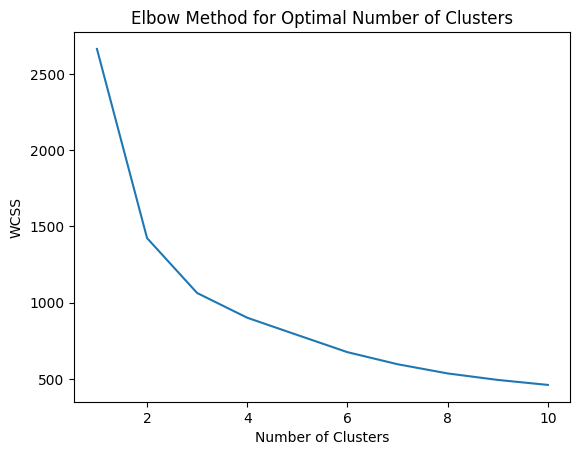

In [45]:
# Extract the relevant features for clustering
clustring_Features = users_data[['gender_encoded', 'age_normalized', 'occupation_normalized','zip-code State']]

# Perform K-means clustering for different number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(clustring_Features)
    wcss.append(kmeans.inertia_)

# Plot the WCSS vs number of clusters
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Performe "users" clustring using Kmeans

In [46]:
# Extract the relevant features for clustering
clustring_Features = users_data[['gender_encoded', 'age_normalized', 'occupation_normalized','zip-code State']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=6, random_state=0)  # Specify the desired number of clusters
kmeans.fit(clustring_Features)  # Fit the K-means model to the data
cluster_labels = kmeans.labels_  # Get the cluster labels for each data point
cluster_centers = kmeans.cluster_centers_  # Get the cluster centers

# Add the cluster labels as a new column to the users_data DataFrame
users_data['Cluster_Label'] = cluster_labels

# Print the resulting DataFrame with the cluster labels
users_data

,userId,gender_encoded,age_normalized,occupation_normalized,zip-code State,Cluster_Label
0,1,0,0.000000,0.50,0.454545,3
1,2,1,1.000000,0.80,0.381818,4
2,3,1,0.436364,0.75,0.472727,4
3,4,1,0.800000,0.35,0.400000,2
4,5,1,0.436364,1.00,0.472727,4
...,...,...,...,...,...,...
6035,6036,0,0.436364,0.75,0.200000,3
6036,6037,0,0.800000,0.05,0.854545,1
6037,6038,0,1.000000,0.05,0.672727,1
6038,6039,0,0.800000,0.00,0.400000,1


In [47]:
# Merge users_data with rating_data based on userId
merged_data = pd.merge(users_data, rating_data, on='userId')
# Merge the resulting dataframe with movie_data based on movieId
merged_data = pd.merge(merged_data, movies_data, on='movieId')

merged_data

,userId,gender_encoded,age_normalized,occupation_normalized,zip-code State,Cluster_Label,movieId,rating,timestamp,title,genres
0,1,0,0.000000,0.50,0.454545,3,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1,1.000000,0.80,0.381818,4,1193,5,978298413,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1,0.436364,0.60,0.200000,4,1193,4,978220179,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1,0.436364,0.35,0.890909,0,1193,4,978199279,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1,0.890909,0.05,0.109091,2,1193,5,978158471,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...,...
1000204,5949,1,0.309091,0.85,0.327273,4,2198,5,958846401,Modulations (1998),Documentary
1000205,5675,1,0.618182,0.70,0.218182,4,2703,3,976029116,Broken Vessels (1998),Drama
1000206,5780,1,0.309091,0.85,0.109091,4,2845,1,958153068,White Boys (1999),Drama
1000207,5851,0,0.309091,1.00,0.472727,3,3607,5,957756608,One Little Indian (1973),Comedy Drama Western


In [38]:
# Filter data for the specific userID
user_id = 1
user_data = merged_data[merged_data['userId'] == user_id]


# Get the cluster label of the user
cluster_label = user_data['Cluster_Label'].iloc[0]

# Filter data for the movies in the same cluster
movies_same_cluster = merged_data[merged_data['Cluster_Label'] == cluster_label]

# Filter movies that the user has not watched before
movies_unwatched = movies_same_cluster[~movies_same_cluster['movieId'].isin(user_data['movieId'])]

# Sort movies by rating in descending order
movies_sorted_by_rating = movies_unwatched.sort_values(by='rating', ascending=False)

# Drop duplicates based on movieId
movies_sorted_by_rating = movies_sorted_by_rating.drop_duplicates(subset='movieId')

# Select the top 10 movies
top_10_movies = movies_sorted_by_rating.head(10)

# Extract the relevant columns for recommendation
recommendation = top_10_movies[['userId', 'movieId', 'rating', 'title', 'genres','Cluster_Label']]

# Display the recommendation
recommendation


,userId,movieId,rating,title,genres,Cluster_Label
1000207,5851,3607,5,One Little Indian (1973),Comedy Drama Western,3
797774,4681,3683,5,Blood Simple (1984),Drama Film-Noir,3
283208,1248,1500,5,Grosse Pointe Blank (1997),Comedy Crime,3
527560,1812,2011,5,Back to the Future Part II (1989),Comedy Sci-Fi,3
910464,2259,3808,5,Two Women (La Ciociara) (1961),Drama War,3
910513,447,3811,5,Breaker Morant (1980),Drama War,3
527215,6036,971,5,Cat on a Hot Tin Roof (1958),Drama,3
910316,3667,1951,5,Oliver! (1968),Musical,3
282564,4086,2599,5,Election (1999),Comedy,3
797176,5728,955,5,Bringing Up Baby (1938),Comedy,3


# Get the Top 10 similar movies for a selected movie using "Title"

In [52]:
movie_Name = 'Aladdin and the King of Thieves (1996)'
# ------------------------------------------------------
#Get the top similar movies for a selected movie
selected_movie = movies_data.loc[movies_data['title'] == movie_Name]
# get the row index of a specific title
idx = movies_data.loc[movies_data['title'] == movie_Name].index[0]

# Loop through each movie in the subset
release_year_diff=[]
# Get cosine similarity scores for the current movie
similarity_scores = list(enumerate(cosine_similarities[idx]))

# Sort by 'similarity' in descending order as primary condition,
# and by absolute difference between 'release_year' and 'target_year' as secondary condition
target_year = selected_movie['release_year'] # target year for release date comparison
movies_data['release_year_diff'] = abs(movies_data['release_year'] - target_year)

# Sort similarity scores in descending order
similarity_scores = sorted(similarity_scores, key=lambda x: (x[1], -movies_data.iloc[x[0]]['release_year_diff']), reverse=True)


# Get top 10 similar movies (excluding the current movie itself)
top_10_similar_movies = [(movies_data.iloc[similarity_score[0]]['title'], similarity_score[1]) for similarity_score in similarity_scores if similarity_score[0] != idx][:20]
# Print similar movies for each movie
print("Similar movies for '{}' are:".format(movie_Name))
for movie, similar_movie_scores in top_10_similar_movies:
    Recomended_Movie_Title = movie
    Recomended_Movie_similarity_with_user_movie = round(similar_movie_scores, 4)
    print("- '{}' with similarity score {}".format(Recomended_Movie_Title, Recomended_Movie_similarity_with_user_movie))
print("------------------------")

Similar movies for 'Aladdin and the King of Thieves (1996)' are:
- 'Toy Story (1995)' with similarity score 1.0
- 'American Tail, An (1986)' with similarity score 1.0
- 'Rugrats Movie, The (1998)' with similarity score 1.0
- 'Bug's Life, A (1998)' with similarity score 1.0
- 'Toy Story 2 (1999)' with similarity score 1.0
- 'Saludos Amigos (1943)' with similarity score 1.0
- 'Chicken Run (2000)' with similarity score 1.0
- 'Adventures of Rocky and Bullwinkle, The (2000)' with similarity score 1.0
- 'Balto (1995)' with similarity score 0.9398
- 'Swan Princess, The (1994)' with similarity score 0.9398
- 'Pinocchio (1940)' with similarity score 0.9398
- 'Aristocats, The (1970)' with similarity score 0.9398
- 'Oliver & Company (1988)' with similarity score 0.9398
- 'Winnie the Pooh and the Blustery Day (1968)' with similarity score 0.9398
- 'Sword in the Stone, The (1963)' with similarity score 0.9398
- 'Fox and the Hound, The (1981)' with similarity score 0.9398
- 'Mulan (1998)' with simil